In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
from datetime import datetime, timedelta
from PyEMD import EMD, EEMD, CEEMDAN
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
def get_stock_data(ticker, start_date, end_date):
    try:
        data = yf.download(ticker, start=start_date, end=end_date)
        return data
    except Exception as e:
        print("Error fetching data:", e)
        return None
    
def calculate_returns(data):
    returns = data.pct_change()
    returns = returns.dropna()
    return returns

In [3]:
ticker = "MSFT"
start_dt = "2023-01-01"
end_dt = "2024-04-20"
data = get_stock_data(ticker=ticker, 
                      start_date=start_dt, 
                      end_date=end_dt)['Adj Close']
ret = calculate_returns(data)
print(ret)

[*********************100%%**********************]  1 of 1 completed

Date
2023-01-04   -0.043743
2023-01-05   -0.029638
2023-01-06    0.011785
2023-01-09    0.009736
2023-01-10    0.007617
                ...   
2024-04-15   -0.019578
2024-04-16    0.002272
2024-04-17   -0.006609
2024-04-18   -0.018381
2024-04-19   -0.012739
Name: Adj Close, Length: 325, dtype: float64


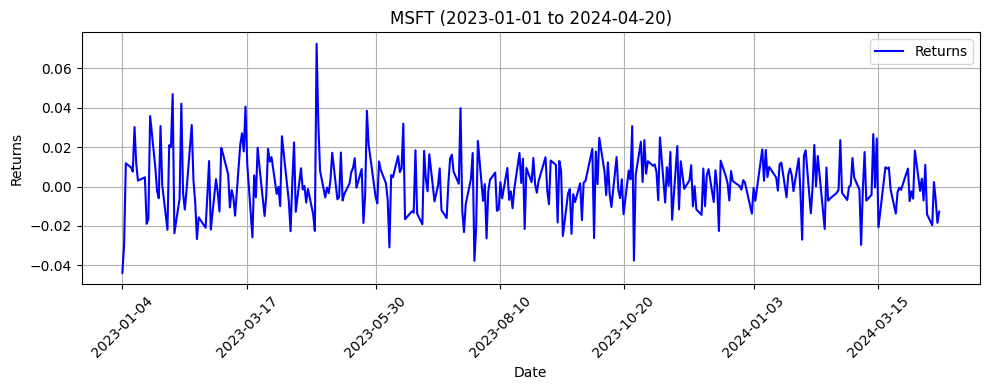

In [4]:
plt.figure(figsize=(10, 4))
plt.plot(ret.index, ret.values, label='Returns', color='blue')
n = 50  
plt.xticks(ret.index[::n], rotation=45)
plt.xlabel('Date')
plt.ylabel('Returns')
plt.title(f'MSFT ({start_dt} to {end_dt})')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Step 1: Find the local extremas (minimas and maximas)

In [5]:
def get_extremas0(signal):
    minima = (np.diff(np.sign(np.diff(signal))) > 0).nonzero()[0] + 1
    maxima = (np.diff(np.sign(np.diff(signal))) < 0).nonzero()[0] + 1
    return minima, maxima

In [6]:
def get_extremas(signal):
    # Find local minima
    minima = (np.diff(np.sign(np.diff(signal))) > 0).nonzero()[0] + 1
    # Find local maxima
    maxima = (np.diff(np.sign(np.diff(signal))) < 0).nonzero()[0] + 1

    # # Include the first and last points as potential extrema if they satisfy the conditions
    # if len(signal) > 0:
    #     if signal[0] <= signal[1]:  # First point is a potential local minimum
    #         minima = np.insert(minima, 0, 0)
    #     else:  # First point is a potential local maximum
    #         maxima = np.insert(maxima, 0, 0)
        
    #     if signal[-1] <= signal[-2]:  # Last point is a potential local minimum
    #         minima = np.append(minima, len(signal) - 1)
    #     else:  # Last point is a potential local maximum
    #         maxima = np.append(maxima, len(signal) - 1)
    
    return minima, maxima


In [7]:
test_len = 100
test = ret[0:test_len]
test_min_idxs, test_max_idxs = get_extremas(test)
test_min, test_max = test[test_min_idxs], test[test_max_idxs]

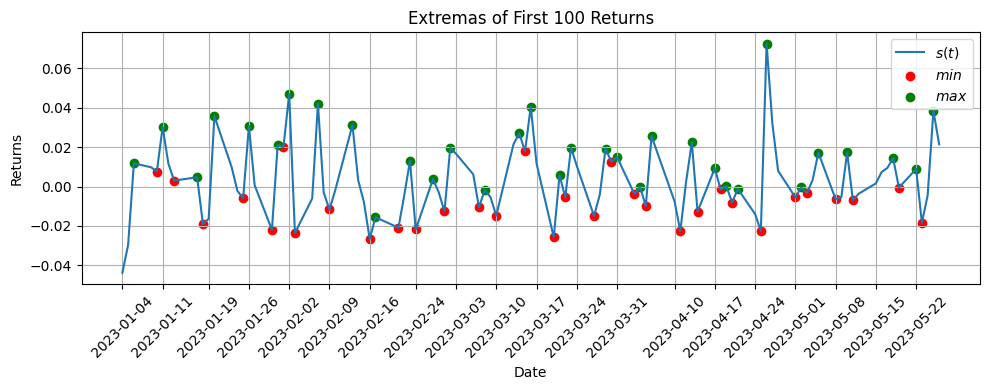

In [9]:
plt.figure(figsize=(10, 4))
plt.plot(test.index, test.values, label='$s(t)$')
plt.scatter(test_min.index, test_min.values, color='r', label="$min$")
plt.scatter(test_max.index, test_max.values, color='g', label='$max$')
n = 5
plt.xticks(test.index[::n], rotation=45)
plt.xlabel('Date')
plt.ylabel('Returns')
plt.title(f'Extremas of First {test_len} Returns')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("step1", dpi=300)
plt.show()

## 2. Fit Envelopes
- $E_{up}(t)$ - Upper Envelope
- $E_{low}(t)$ - lower Envelope

In [10]:
# def get_cubicSpline(extrema, size):
#     dates_numeric = np.array(extrema.index.astype(np.int64))
#     cubic_spline = CubicSpline(dates_numeric, extrema.values)
#     interpolated_dates_numeric = np.linspace(dates_numeric[0], dates_numeric[-1], num=size)
#     interpolated_values = cubic_spline(interpolated_dates_numeric)
#     interpolated_dates = pd.to_datetime(interpolated_dates_numeric, unit='ns')
#     return interpolated_dates, interpolated_values
def get_cubicSpline(extrema, size):
    dates_numeric = np.array(extrema.index.astype(np.int64))
    cubic_spline = CubicSpline(dates_numeric, extrema.values)
    
    # Ensure that the interpolated array covers the entire range of dates_numeric
    interpolated_dates_numeric = np.linspace(dates_numeric[0], dates_numeric[-1], num=size, endpoint=True)
    
    interpolated_values = cubic_spline(interpolated_dates_numeric)
    interpolated_dates = pd.to_datetime(interpolated_dates_numeric, unit='ns')
    return interpolated_dates, interpolated_values

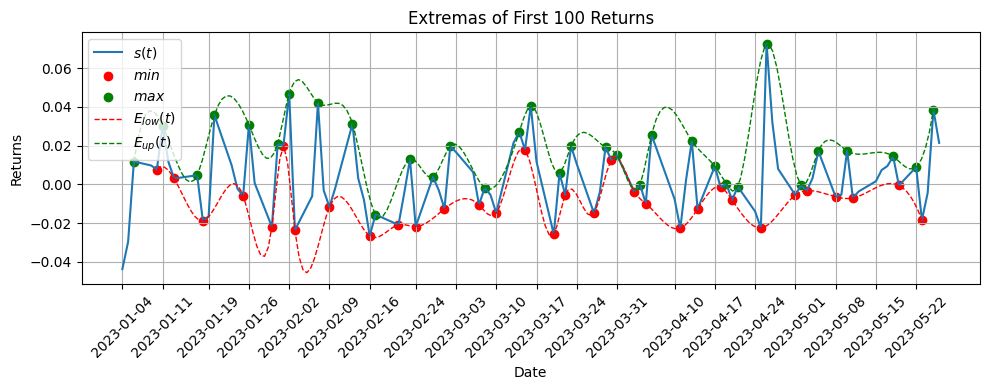

In [12]:
# cubic spline
size = 2*len(test)
test_min_interp_dates, test_min_interp = get_cubicSpline(test_min, size=size)
test_max_interp_dates, test_max_interp = get_cubicSpline(test_max, size=size)

# plot
plt.figure(figsize=(10, 4))
plt.plot(test.index, test.values, label='$s(t)$')
plt.scatter(test_min.index, test_min.values, color='r', label="$min$")
plt.scatter(test_max.index, test_max.values, color='g', label='$max$')
plt.plot(test_min_interp_dates, test_min_interp, label="$E_{low}(t)$", color='r', linestyle='--', linewidth=1)
plt.plot(test_max_interp_dates, test_max_interp, label="$E_{up}(t)$", color='g', linestyle='--', linewidth=1)
n = 5
plt.xticks(test.index[::n], rotation=45)
plt.xlabel('Date')
plt.ylabel('Returns')
plt.title(f'Extremas of First {test_len} Returns')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("step2", dpi=300)
plt.show()

## 3. Mean Envelope

$$E_{mean}(t) = \frac{E_{low}(t) + E_{up}(t)}{2}$$

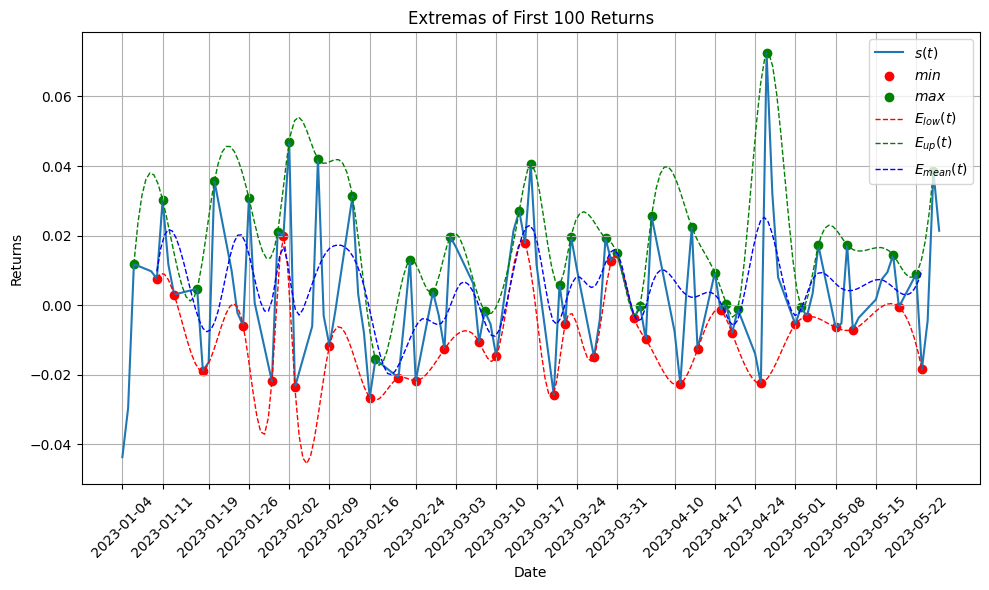

In [14]:
mean_envelope = np.mean([test_min_interp, test_max_interp], axis=0)

# plot
plt.figure(figsize=(10, 6))
plt.plot(test.index, test.values, label='$s(t)$')
plt.scatter(test_min.index, test_min.values, color='r', label="$min$")
plt.scatter(test_max.index, test_max.values, color='g', label='$max$')
plt.plot(test_min_interp_dates, test_min_interp, label="$E_{low}(t)$", color='r', linestyle='--', linewidth=1)
plt.plot(test_max_interp_dates, test_max_interp, label="$E_{up}(t)$", color='g', linestyle='--', linewidth=1)
plt.plot(test_min_interp_dates, mean_envelope, label="$E_{mean}(t)$", color='b', linestyle='--', linewidth=1)

n = 5
plt.xticks(test.index[::n], rotation=45)
plt.xlabel('Date')
plt.ylabel('Returns')
plt.title(f'Extremas of First {test_len} Returns')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("step3", dpi=300)
plt.show()

## 4. IMF 1 and Residual 1

$$
    res(t) = s(t) - E_{mean}(t)
$$

In [15]:
dates1 = np.array([dt.date() for dt in test.index])
dates2 = np.array([dt.date() for dt in test_min_interp_dates])

dates2_value_dict = {date:value for date, value in zip(dates2, mean_envelope)}
unique_dates2 = set(dates2)
new_dates2, new_values2 = [], []
for date in unique_dates2:
    new_dates2.append(date)
    new_values2.append(dates2_value_dict[date])
mean_envelope_new = pd.Series(new_values2, index=new_dates2)

res = test - mean_envelope_new
IMF1 = res[test.index].fillna(0)

0.005347855673384713

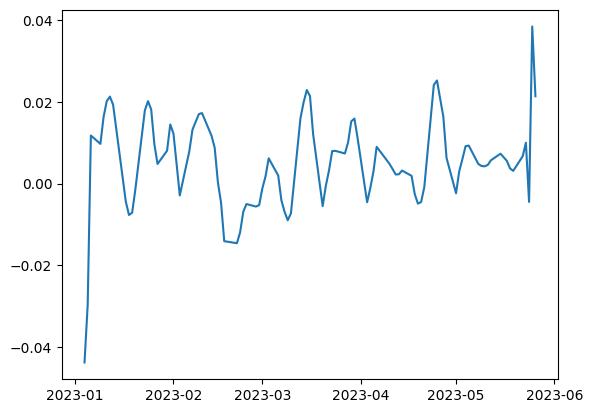

In [16]:
residual = test - IMF1
plt.plot(residual)
np.mean(residual)

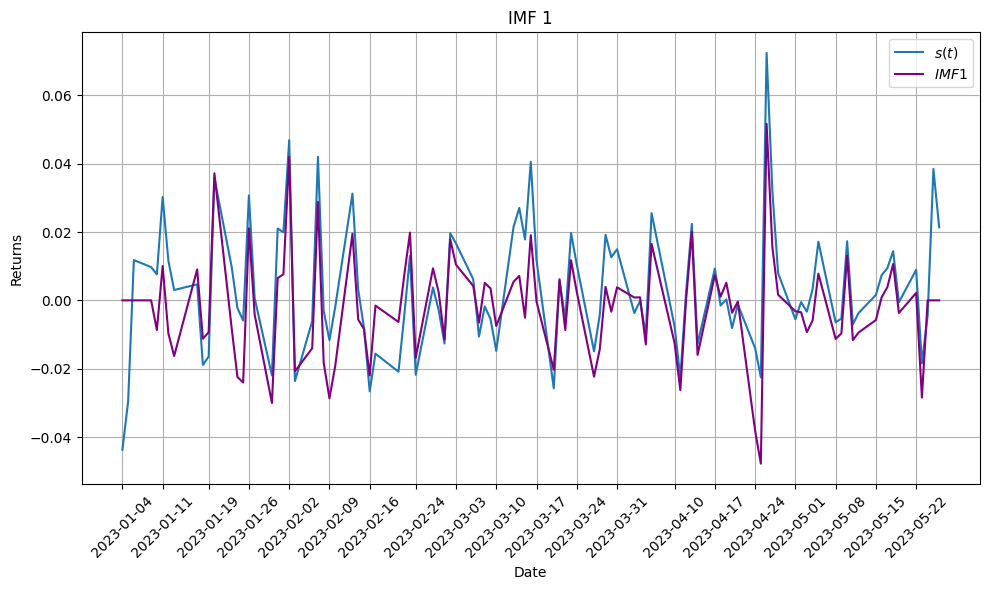

In [19]:
# plot
plt.figure(figsize=(10, 6))
plt.plot(test.index, test.values, label='$s(t)$')
# plt.scatter(test_min.index, test_min.values, color='r', label="$min$")
# plt.scatter(test_max.index, test_max.values, color='g', label='$max$')
# plt.plot(test_min_interp_dates, test_min_interp, label="$E_{low}(t)$", color='r', linestyle='--', linewidth=1)
# plt.plot(test_max_interp_dates, test_max_interp, label="$E_{up}(t)$", color='g', linestyle='--', linewidth=1)
# plt.plot(test_min_interp_dates, mean_envelope, label="$E_{mean}(t)$", color='b', linestyle='--', linewidth=1)
plt.plot(IMF1.index, IMF1.values, color='purple', label="$IMF 1$")
# plt.plot(residual.index, residual.values, color='green', label="Residual 1")
n = 5
plt.xticks(test.index[::n], rotation=45)
plt.xlabel('Date')
plt.ylabel('Returns')
plt.title(f'IMF 1')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("step4", dpi=300)
plt.show()

In [58]:
def extract_residual(signal):

    # step 1: find the extremas
    min_idxs, max_idxs = get_extremas(signal)
    minima, maxima = signal[min_idxs], signal[max_idxs]

    # step 2: fit the envelopes using cubic spline
    size = 2*len(test)
    min_interp_dates, min_interp = get_cubicSpline(minima, size=size)
    max_interp_dates, max_interp = get_cubicSpline(maxima, size=size)

    # step 3: calculate the mean envelope
    mean_envelope = np.mean([min_interp, max_interp], axis=0)

    # step 4: calculate the residual (IMF)
    dates1 = np.array([dt.date() for dt in signal.index])
    dates2 = np.array([dt.date() for dt in min_interp_dates])

    dates2_value_dict = {date:value for date, value in zip(dates2, mean_envelope)}
    unique_dates2 = set(dates2)
    new_dates2, new_values2 = [], []
    for date in unique_dates2:
        new_dates2.append(date)
        new_values2.append(dates2_value_dict[date])
    mean_envelope_new = pd.Series(new_values2, index=new_dates2)

    res = signal - mean_envelope_new
    # IMF1 = res[signal.index].fillna(0)

    return res[signal.index].fillna(0)

## 5. Extract the Subsequent IMFs

In [59]:
# extract IMF1
IMF1 = extract_residual(signal=test)

In [60]:
# extract IMF2
test2 = test - IMF1
IMF2 = extract_residual(signal=test2)

In [61]:
# extract IMF3
test3 = test2 - IMF2
IMF3 = extract_residual(signal=test3)

In [62]:
# extract IMF4
test4 = test3 - IMF3
IMF4 = extract_residual(signal=test4)

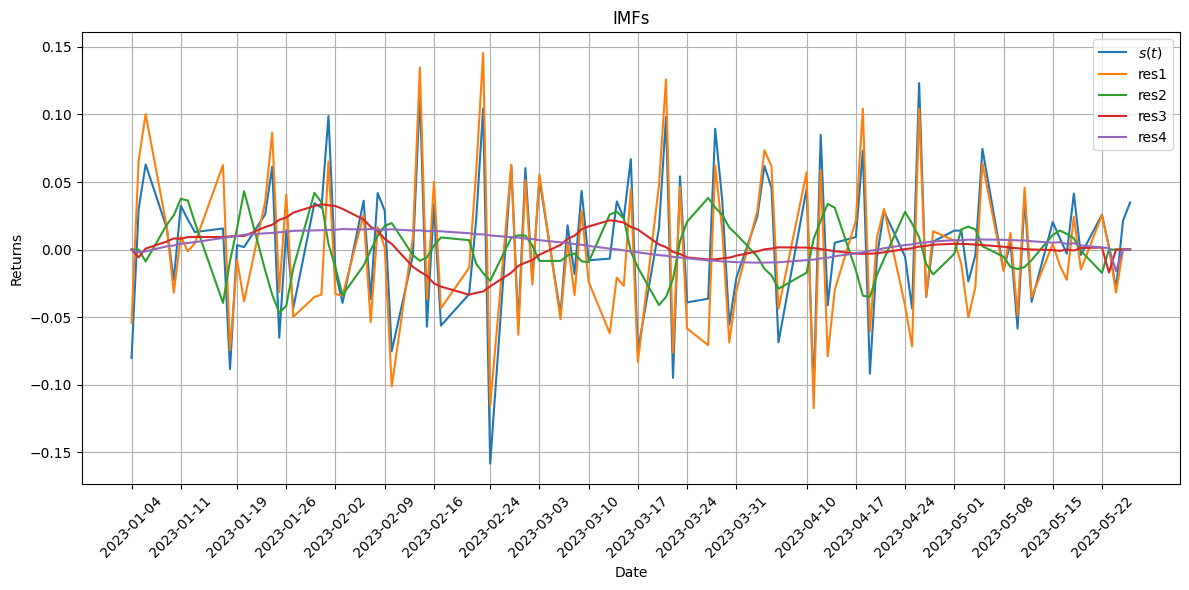

In [64]:
plt.figure(figsize=(12, 6))

plt.plot(test.index, test.values, label='$s(t)$')
plt.plot(IMF1.index, IMF1.values, label="res1")
plt.plot(IMF2.index, IMF2.values, label="res2")
plt.plot(IMF3.index, IMF3.values, label="res3")
plt.plot(IMF4.index, IMF4.values, label="res4")

n = 5
plt.xticks(test.index[::n], rotation=45)
plt.xlabel('Date')
plt.ylabel('Returns')
plt.title(f'IMFs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [76]:
# def get_EMD(signal, max_iterations=100, threshold=0.01):
#     residual = signal.copy()
#     IMFs = []
    
#     # Perform EMD iterations
#     for _ in range(max_iterations):
#         IMF = extract_IMF(residual)  
#         IMFs.append(IMF)
#         residual = residual - IMF
        
#         if np.std(residual) < threshold:
#             break  
#     return IMFs

# def get_EMD(signal, max_iterations=100, std_threshold=0.01, energy_threshold=0.001):
#     """
#     Perform Empirical Mode Decomposition (EMD) on the input signal.

#     Parameters:
#         signal (array-like): Input signal to decompose.
#         max_iterations (int): Maximum number of iterations for the EMD algorithm.
#         std_threshold (float): Threshold for standard deviation of residual signal.
#         energy_threshold (float): Threshold for energy of residual signal.

#     Returns:
#         list: List of Intrinsic Mode Functions (IMFs) obtained from the EMD decomposition.
#     """
#     residual = signal.copy()
#     IMFs = []

#     # Compute energy of original signal
#     original_energy = np.sum(residual ** 2)

#     # Perform EMD iterations
#     for _ in range(max_iterations):
#         IMF = extract_IMF(residual)
#         IMFs.append(IMF)
#         residual = residual - IMF

#         # Check convergence based on standard deviation and energy threshold
#         residual_energy = np.sum(residual ** 2)
#         if (np.std(residual) < std_threshold) or (residual_energy / original_energy < energy_threshold):
#             break

#     return IMFs

def get_EMD(signal, max_iterations=100, threshold=0.01):
    """
    Perform Empirical Mode Decomposition (EMD) on the input signal.

    Parameters:
        signal (array-like): Input signal to decompose.
        max_iterations (int): Maximum number of iterations for the EMD algorithm.
        std_threshold (float): Threshold for standard deviation of residual signal.
        energy_threshold (float): Threshold for energy of residual signal.

    Returns:
        list: List of Intrinsic Mode Functions (IMFs) obtained from the EMD decomposition.
    """
    original_signal = signal
    res1 = signal.copy()
    IMFs = []

    # IMF LOOP
    while(True):
        res2 = extract_residual(res1)
        sum=0
        for _ in range(len(residual)):
            num = (res2 - res1)**2
            den = (res1)**2
            term = num/den
            sum+=term
            print(sum)
            if sum < threshold:
                # we got the IMF! (zero-mean residual)
                IMF = res2
                IMFs.append(IMF)

                # let us move on to find the next IMF:
                res1 = original_signal - IMF
                break;
            else:
                # we did not find the IMF:
                res1 = res2
        
    return IMFs

In [87]:
sum((signal - IMF)**2 / signal**2)

854.646557710389

In [83]:
signal = test
res = signal.copy()
IMF = extract_residual(res)
res_sum = np.sum((signal - IMF) ** 2 / signal ** 2)
print(res_sum)

854.6465577103896


In [93]:
def get_EMD(signal, epsilon=1000):
    original_signal = signal
    IMFs = []

    while True:
        res = signal.copy()  # Initialize residual as the original signal
        res_sum = 0  # Initialize sum of squared differences

        # Iterate until convergence
        while True:
            IMF = extract_residual(res)  # Extract residual
            res_sum = np.sum((signal - IMF) ** 2 / signal ** 2)  # Calculate sum of squared differences
            print(res_sum)
            if res_sum < epsilon:
                IMFs.append(IMF)  # Store IMF
                signal -= IMF  # Subtract IMF from the original signal
                break  # Exit loop if convergence criterion met
            else:
                res = extract_residual(IMF)  # Update residual for the next iteration

        if np.allclose(signal, np.zeros_like(signal)):
            break  # Exit loop if the signal becomes zero
    return IMFs

In [94]:
IMFs = get_EMD(signal=test)
print(f"num IMFs: {len(IMFs)}")

7093.325659989459
3375.564847113759
3823.0730359159065
4751.459797463095
5925.935270805338
7206.8762156472885
8231.256466440926
9599.460850059542
11290.690961594304
12932.587281754215
14434.65892118015
15783.972931509805
16989.74830564185
21005.87431294837
16869.829141255694
20053.425377947056
20201.778340425077
19385.412788160644
19566.272732646143
20407.40503173383
21476.224125764766
22550.278136673813
23566.00431882655
24510.39364386174
25357.044235843667
26124.93340111546
26831.24700557814
20958.98870334671
29504.79278047238
28297.631386895984
28526.668869477962
28870.622140619656
31587.192159812726
31971.811882632403
32508.879494873523
33183.7272803799
37102.174721742675
34626.52166918152
35808.78268067015
34850.34316210559
35120.918319766715
35511.8476264378
36261.175964227965
36576.3409033506
37099.5911621888
40651.65273159725
38091.71402572214
39013.60247236713
39266.30676687888
40823.974937207255
41204.45534955211
41558.364982230596
41954.29608442817
42362.28967016443
45852.17

KeyboardInterrupt: 

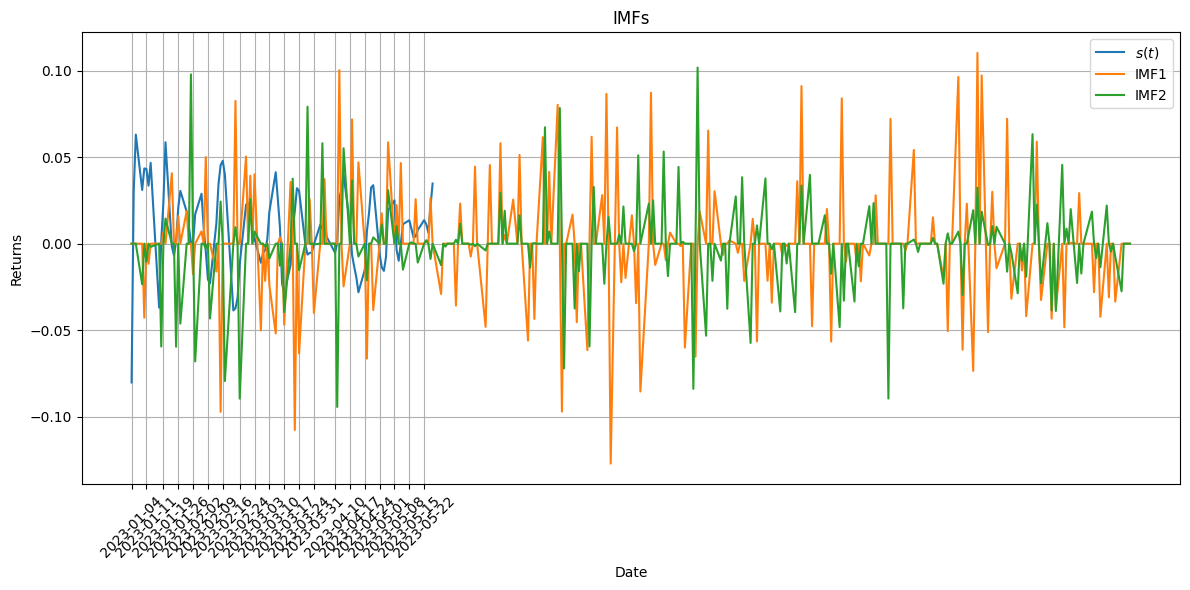

In [95]:
plt.figure(figsize=(12, 6))
plt.plot(test.index, test.values, label='$s(t)$')
plt.plot(IMFs[0].index, IMFs[0].values, label="IMF1")
plt.plot(IMFs[1].index, IMFs[1].values, label="IMF2")

n = 5
plt.xticks(test.index[::n], rotation=45)
plt.xlabel('Date')
plt.ylabel('Returns')
plt.title(f'IMFs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [24]:
IMFs = get_EMD(signal=ret)
print(f"num IMFs: {len(IMFs)}")

num IMFs: 7


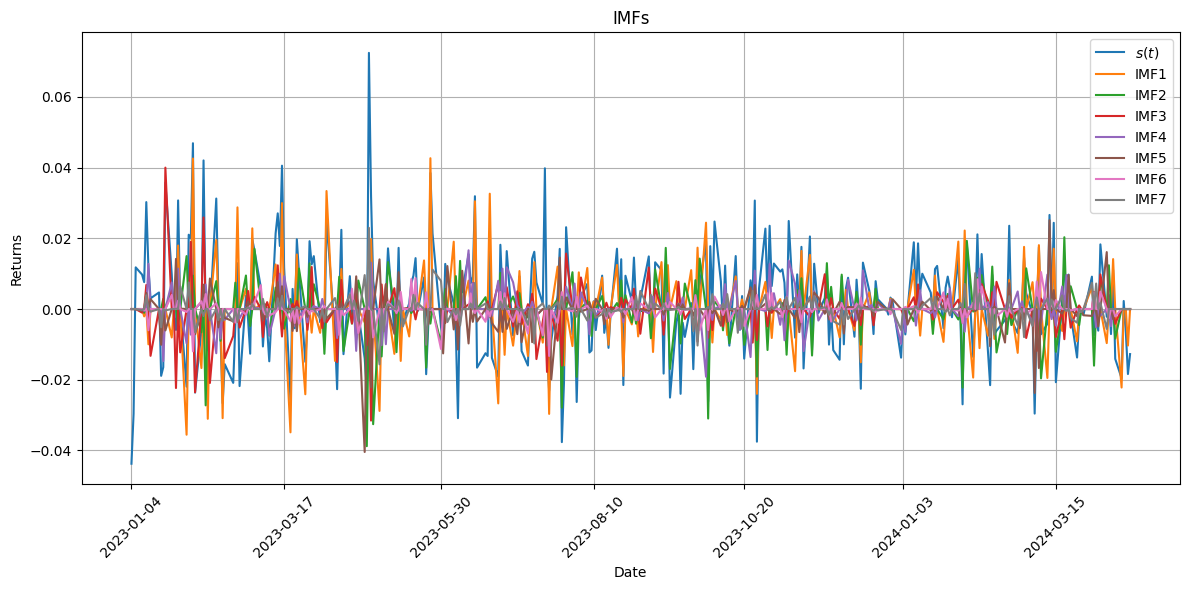

In [25]:
plt.figure(figsize=(12, 6))
plt.plot(ret.index, ret.values, label='$s(t)$')
plt.plot(IMFs[0].index, IMFs[0].values, label="IMF1")
plt.plot(IMFs[1].index, IMFs[1].values, label="IMF2")
plt.plot(IMFs[2].index, IMFs[2].values, label="IMF3")
plt.plot(IMFs[3].index, IMFs[3].values, label="IMF4")
plt.plot(IMFs[4].index, IMFs[4].values, label="IMF5")
plt.plot(IMFs[5].index, IMFs[5].values, label="IMF6")
plt.plot(IMFs[6].index, IMFs[6].values, label="IMF7")

n = 50
plt.xticks(ret.index[::n], rotation=45)
plt.xlabel('Date')
plt.ylabel('Returns')
plt.title(f'IMFs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## 6. Using Noisy-Signal with EMD

[*********************100%%**********************]  1 of 1 completed

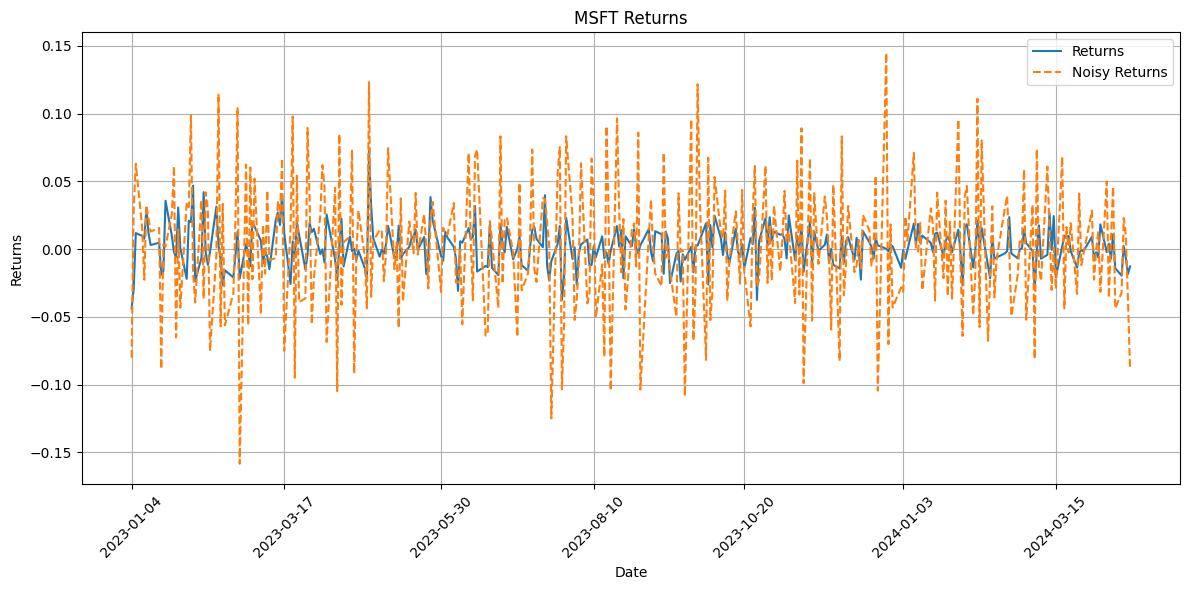

In [27]:
# get the ticker data
ticker = "MSFT"
start_dt = "2023-01-01"
end_dt = "2024-04-20"
data = get_stock_data(ticker=ticker, 
                      start_date=start_dt, 
                      end_date=end_dt)['Adj Close']

# noise characteristics
mean = 0
std_dev = 10
num_samples = len(data)
gaussian_noise = np.random.normal(mean, std_dev, num_samples)
noisy_data = data + gaussian_noise

# calculate returns
clean_ret = calculate_returns(data)
ret = calculate_returns(noisy_data)

# plot the returns and noisy-returns
plt.figure(figsize=(12, 6))

plt.plot(clean_ret.index, clean_ret.values, label="Returns")
plt.plot(ret.index, ret.values, label="Noisy Returns", linestyle="--")
n = 50
plt.xticks(ret.index[::n], rotation=45)
plt.xlabel('Date')
plt.ylabel('Returns')
plt.title(f'MSFT Returns')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

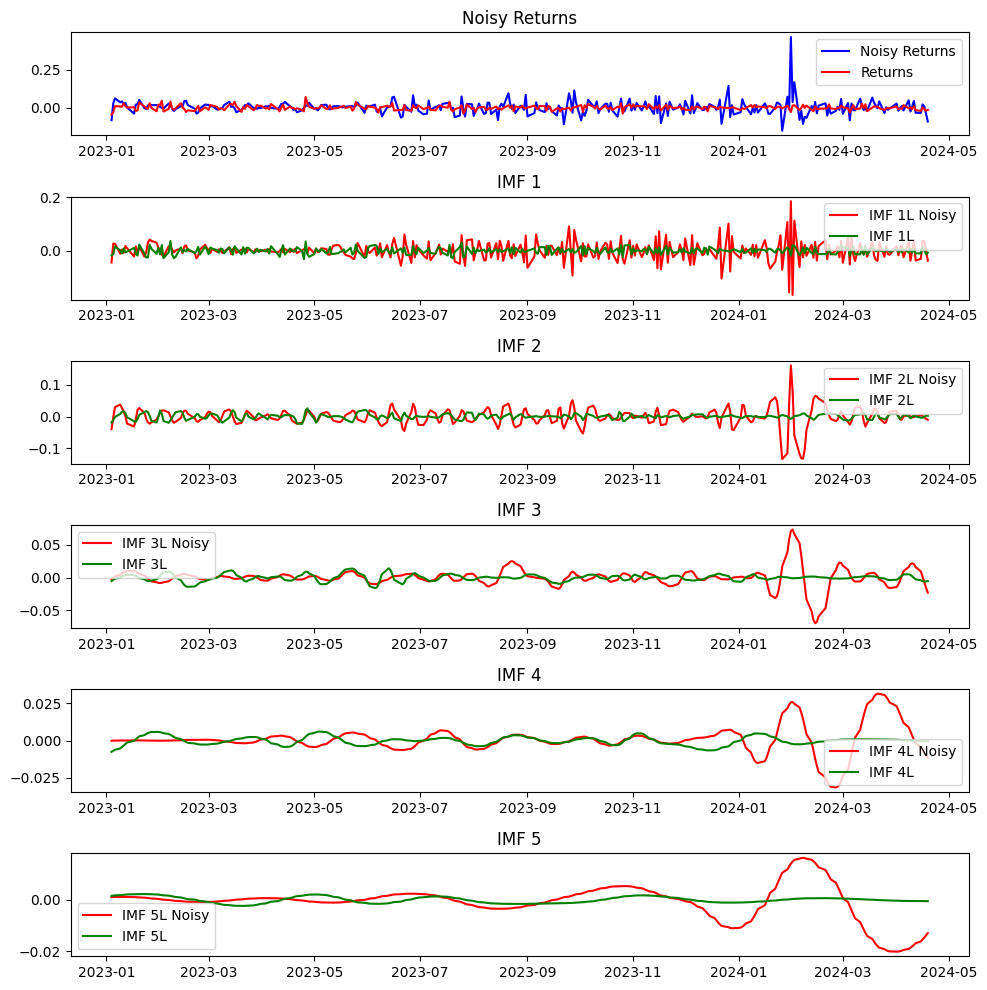

In [120]:
# WAY 1: using my code
# IMFs = get_EMD(signal=ret)
# N = len(IMFs)
# print(f"num IMFs: {len(IMFs)}")

# WAY 2: using library
s = ret.values
t = ret.index

s_clean = clean_ret.values
t_clean = clean_ret.index

# Execute EMD on signal
IMF = EMD().emd(s,t)
IMF_clean = EMD().emd(s_clean, t_clean)
N_IMF = IMF.shape[0]+1

# plot the IMFs
fig, axs = plt.subplots(6, 1, figsize=(10, 10))

# signal
axs[0].plot(ret.index, ret.values, label="Noisy Returns", color='blue')
axs[0].plot(clean_ret.index, clean_ret.values, label="Returns", color='red')
axs[0].set_title("Noisy Returns")
axs[0].legend()

# IMF 1
# axs[1].plot(IMFs[0].index, IMFs[0].values, label="IMF 1", color='green')
axs[1].plot(ret.index, IMF[0], label="IMF 1L Noisy", color='red')
axs[1].plot(ret.index, IMF_clean[0], label="IMF 1L", color='green')
axs[1].set_title("IMF 1")
axs[1].legend()

# IMF 2
# axs[2].plot(IMFs[1].index, IMFs[1].values, label="IMF 2", color='green')
axs[2].plot(ret.index, IMF[1], label="IMF 2L Noisy", color='red')
axs[2].plot(ret.index, IMF_clean[1], label="IMF 2L", color='green')
axs[2].set_title("IMF 2")
axs[2].legend()

# IMF 3
# axs[2].plot(IMFs[1].index, IMFs[1].values, label="IMF 2", color='green')
axs[3].plot(ret.index, IMF[2], label="IMF 3L Noisy", color='red')
axs[3].plot(ret.index, IMF_clean[2], label="IMF 3L", color='green')

axs[3].set_title("IMF 3")
axs[3].legend()

# IMF 4
# axs[2].plot(IMFs[1].index, IMFs[1].values, label="IMF 2", color='green')
axs[4].plot(ret.index, IMF[3], label="IMF 4L Noisy", color='red')
axs[4].plot(ret.index, IMF_clean[3], label="IMF 4L", color='green')
axs[4].set_title("IMF 4")
axs[4].legend()

# IMF 5
# axs[2].plot(IMFs[1].index, IMFs[1].values, label="IMF 2", color='green')
axs[5].plot(ret.index, IMF[4], label="IMF 5L Noisy", color='red')
axs[5].plot(ret.index, IMF_clean[4], label="IMF 5L", color='green')
axs[5].set_title("IMF 5")
axs[5].legend()



# # IMF 6
# # axs[3].plot(IMFs[5].index, IMFs[5].values, label="IMF 6", color='green')
# axs[3].plot(ret.index, IMF[5], label="IMF 6L", color='red')
# axs[3].set_title("IMF 7")
# axs[3].legend()

# # IMF 80
# # axs[4].plot(IMFs[79].index, IMFs[80].values, label="IMF 80", color='green')
# axs[4].set_title("IMF 80")
# axs[4].legend()

# # IMF 100
# # axs[5].plot(IMFs[99].index, IMFs[99].values, label="IMF 100", color='green')
# axs[5].set_title("IMF 100")
# axs[5].legend()

plt.tight_layout()
plt.show()

### 6.1 Problem with EMD

Mode Mixing: In the decomposition in several modes above, it is not perfectly performed. We can see in teh above figure that in the econd and third IMF, there exists a multiple dominant oscillation frequency but they should have been separated into different IMFs and hence we have a problem of mode mixing in this method.
=> Physical meaning of IMFs is compromised!

## 7.EEMD - Ensemble Empirical Mode Decomposition

In this method, the input data is directly disturbed by the noise!

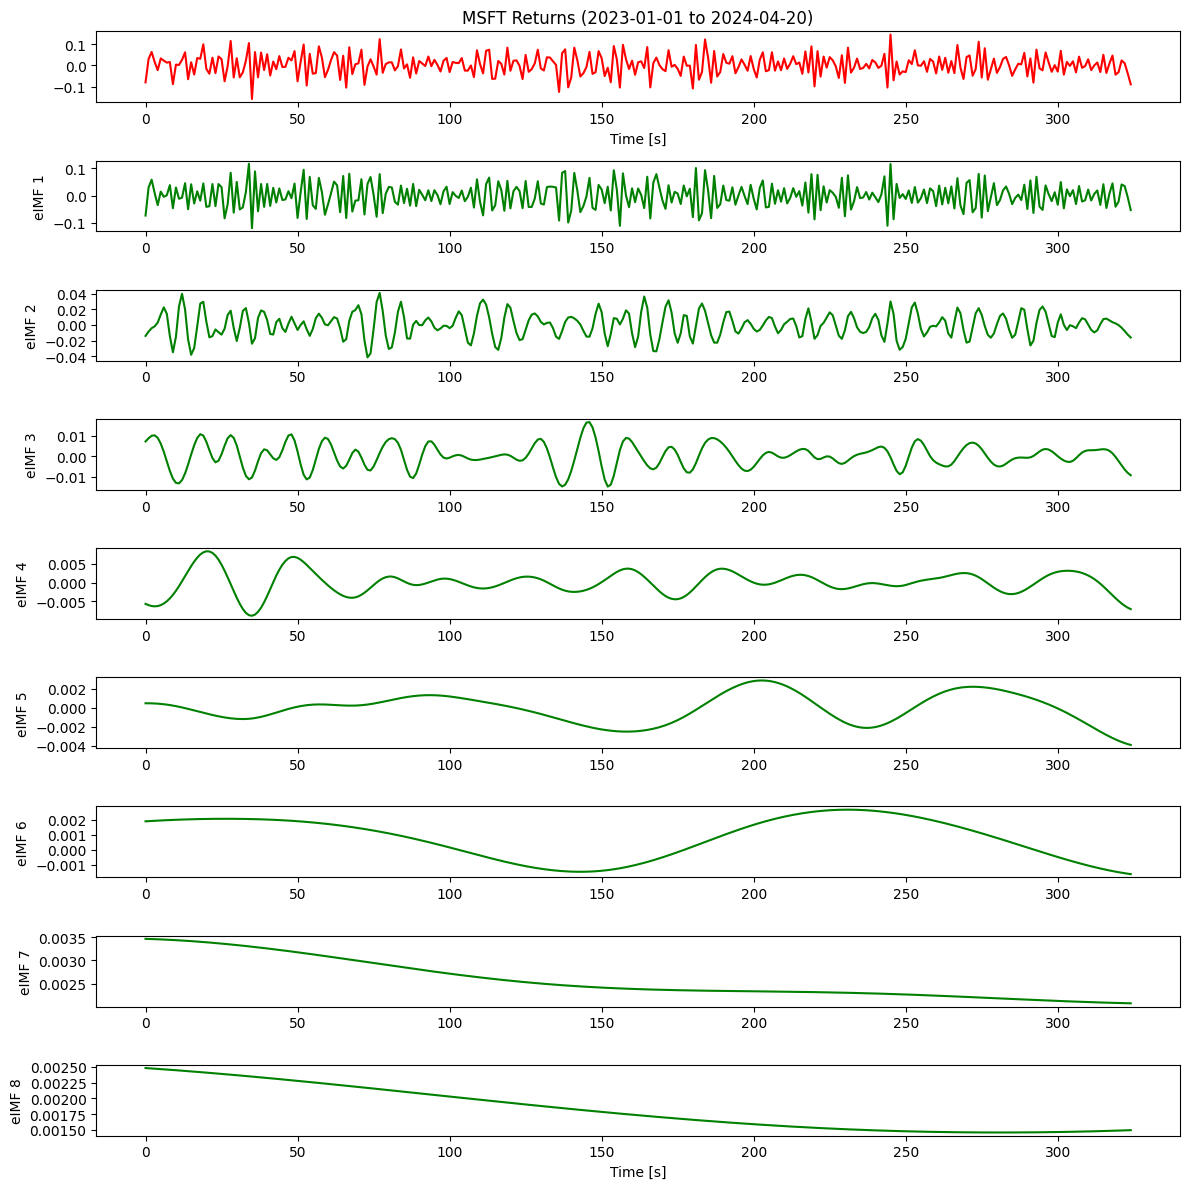

In [29]:
# data
s = ret.values
t = np.arange(len(ret.values))

# perform emd on the noisy signal
eemd = EEMD()

# detect extrema using parabolic method
emd = eemd.EMD
emd.extrema_detection="parabol"

# Execute EEMD on s
eIMF = eemd.eemd(s,t)
nIMF = eIMF.shape[0]

# plot results
plt.figure(figsize=(12,12))
plt.subplot(nIMF+1, 1, 1)
plt.plot(t, s, 'r')
plt.title(f"MSFT Returns ({start_dt} to {end_dt})")
plt.xlabel("Time [s]")

for n in range(nIMF):
    plt.subplot(nIMF+1, 1, n+2)
    plt.plot(t, eIMF[n], 'g')
    plt.ylabel("eIMF %i" %(n+1))
    plt.locator_params(axis='y', nbins=5)

plt.xlabel("Time [s]")
plt.tight_layout()
plt.show()

## 8. CEEMDAN

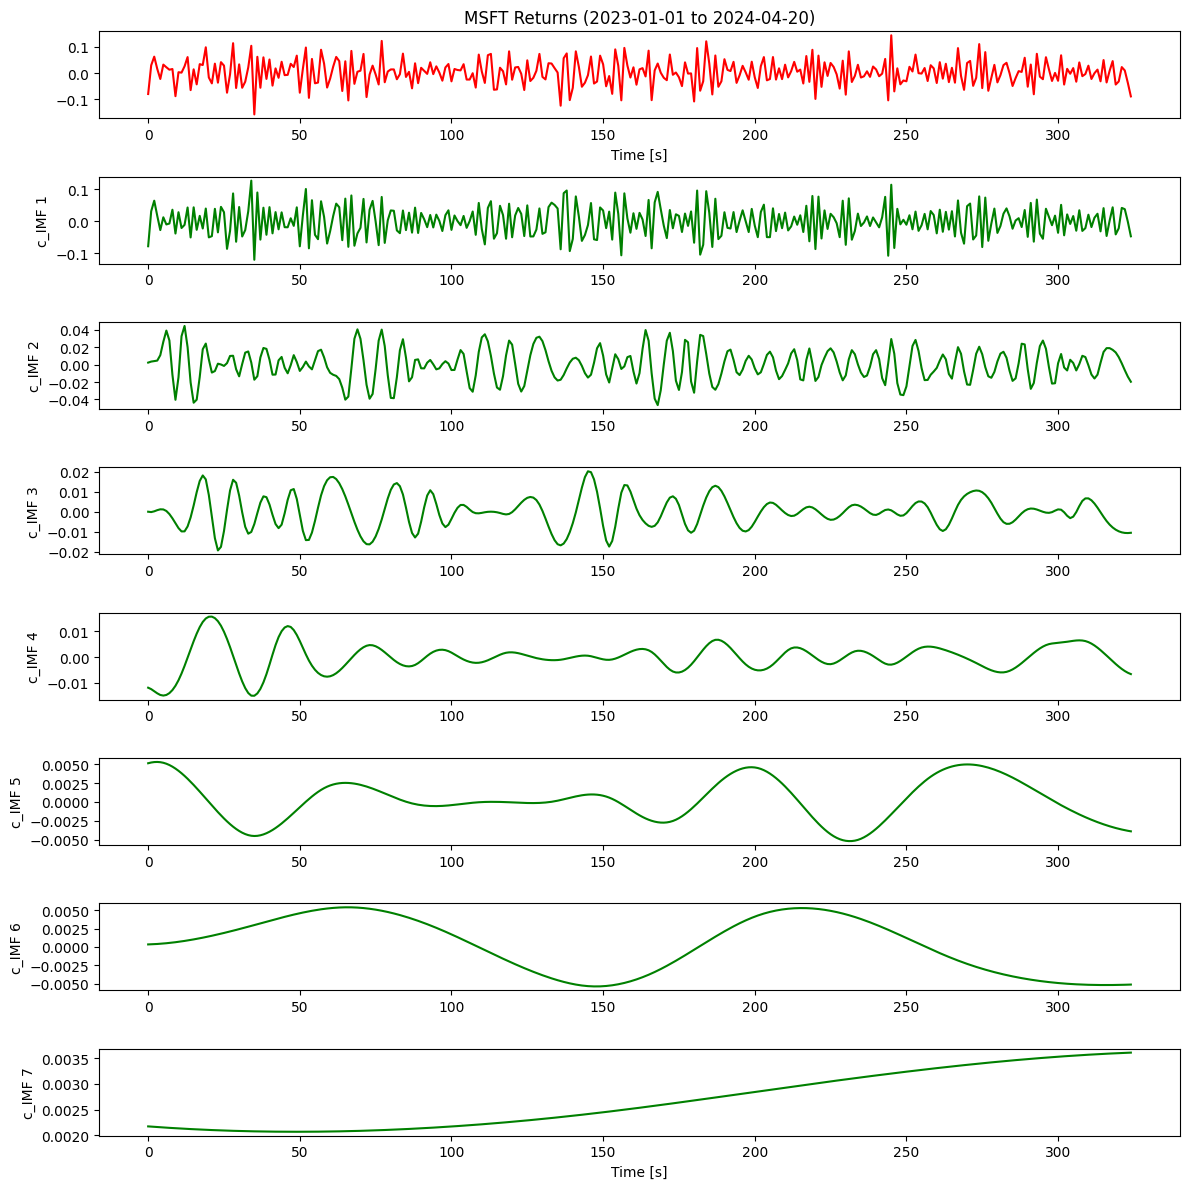

In [30]:
# Execute EEMD on s
ceemdan = CEEMDAN()
c_IMF = ceemdan(s)
nCIMF = c_IMF.shape[0]

# plot results
plt.figure(figsize=(12,12))
plt.subplot(nCIMF+1, 1, 1)
plt.plot(t, s, 'r')
plt.title(f"MSFT Returns ({start_dt} to {end_dt})")
plt.xlabel("Time [s]")

for n in range(nCIMF):
    plt.subplot(nCIMF+1, 1, n+2)
    plt.plot(t, c_IMF[n], 'g')
    plt.ylabel("c_IMF %i" %(n+1))
    plt.locator_params(axis='y', nbins=5)

plt.xlabel("Time [s]")
plt.tight_layout()
plt.show()

## 9. ICEEMDAN